# Simulating Semi-Realistic Gravitational Wave Signals for Machine Learning

This notebook generates a binary classification dataset of gravitational wave (GW) signals for machine learning, using only physics-inspired analytical models. The dataset contains both noisy GW signals and pure noise, labeled accordingly.

## Overview

We simulate gravitational wave signals from binary black hole inspirals using the leading-order post-Newtonian (PN) approximation, and inject them into Gaussian white noise with variable signal-to-noise ratios (SNRs).

#### 1. **Source Parameters**
We model a binary system with component masses:
$$ m_1, m_2 \in [5, 80] \, M_\odot $$
and a luminosity distance:
$$ D_L \in [100, 2000] \, \text{Mpc} $$
We also randomize the inclination angle $ \iota \in [0, \pi] $.

The **chirp mass** is computed as:
$$ \mathcal{M} = (m_1 + m_2) \cdot \left( \frac{m_1 m_2}{(m_1 + m_2)^2} \right)^{3/5} $$

Converted to seconds:
$$ \mathcal{M}_{\text{sec}} = \frac{G \mathcal{M}}{c^3} $$

#### 2. **Time-Frequency Evolution**

We define time to coalescence as:
$$ \tau = t_c - t $$
Then use the PN approximation to compute the instantaneous GW frequency:
$$ f(t) = \frac{1}{8 \pi \mathcal{M}_{\text{sec}}} \left( \frac{5 \mathcal{M}_{\text{sec}}}{\tau} \right)^{3/8} $$

The GW phase is obtained by integrating the frequency:
$$ \phi(t) = 2\pi \int f(t) \, dt $$


#### 3. **Amplitude and Polarization**

The amplitude of the GW strain scales as:
$$ A(t) \propto \frac{\mathcal{M}^{5/3} f(t)^{2/3}}{D_L} $$

We only generate the $ h_+(t) $ polarization:
$$ h_+(t) = A(t) \cdot (1 + \cos^2 \iota) \cdot \cos(\phi(t)) $$


#### 4. **Noise Injection and SNR Control**

White Gaussian noise is generated with a fixed standard deviation. We scale the signal to achieve a desired target SNR using:
$$ \text{SNR} = \frac{\sqrt{\langle h^2(t) \rangle}}{\sigma_{\text{noise}}} $$

To match a desired SNR:
$$ h_{\text{scaled}}(t) = h(t) \cdot \frac{\text{SNR} \cdot \sigma_{\text{noise}}}{\sqrt{\langle h^2(t) \rangle}} $$


### Dataset Composition

We generate a dataset of $N$ samples:
- Half contain a **GW signal injected into noise** (label = 1)
- Half contain **pure noise only** (label = 0)

Each sample has shape $(T,)$ where $T = \text{duration} \times \text{sampling rate}$.


### Output

- `signals.npy`: $(N, T)$ array of time-series data
- `labels.npy`: binary labels (0 = noise, 1 = signal)

This dataset is suitable for training classifiers, such as convolutional or recurrent neural networks, to distinguish weak GW signals from noise.


In [1]:
import numpy as np

# Constants
G = 6.67430e-11  # m^3 / kg / s^2
c = 299792458    # m/s
M_sun = 1.98847e30  # kg
parsec = 3.085677581491367e16  # meters
Mpc = 1e6 * parsec

def simulate_gw_inspiral(m1_solar=30, m2_solar=30, DL_Mpc=400,
                         duration=2.0, fs=4096, inclination=0.0,
                         tc=None, phi_c=0.0, taper=True):
    """
    Simulate a realistic inspiral gravitational wave strain (h_plus only).

    Parameters:
    - m1_solar, m2_solar: Masses of binary components in solar masses
    - DL_Mpc: Luminosity distance in Megaparsecs
    - duration: Duration of the signal in seconds
    - fs: Sampling frequency in Hz
    - inclination: Inclination angle in radians (0 = face-on)
    - tc: Coalescence time (defaults to duration)
    - phi_c: Coalescence phase offset
    - taper: If True, zeroes the signal after coalescence

    Returns:
    - t: Time array
    - h_plus: Simulated GW strain (plus polarization)
    """
    # Convert units
    m1 = m1_solar * M_sun
    m2 = m2_solar * M_sun
    DL = DL_Mpc * Mpc
    M = m1 + m2
    eta = (m1 * m2) / M**2
    Mc = M * eta**(3/5)  # chirp mass
    Mc_sec = G * Mc / c**3  # chirp mass in seconds

    # Time array
    t = np.linspace(0, duration, int(fs * duration), endpoint=False)
    dt = t[1] - t[0]

    # Coalescence time
    if tc is None:
        tc = duration

    # Time to coalescence
    tau = tc - t
    tau[tau <= 0] = 1e-6  # prevent division by zero

    # Frequency evolution
    f = (1 / (8 * np.pi * Mc_sec)) * (5 * Mc_sec / tau)**(3/8)

    # Phase evolution
    phi = 2 * np.pi * np.cumsum(f) * dt + phi_c

    # Amplitude evolution
    amp = (Mc_sec**(5/3)) * (np.pi * f)**(2/3)

    # Polarization factors
    F_plus = (1 + np.cos(inclination)**2)

    # Final waveform (plus polarization only)
    h_plus = (4 * amp * F_plus / DL) * np.cos(phi)

    # Taper after coalescence
    if taper:
        h_plus[t >= tc] = 0

    return t, h_plus

def generate_white_noise(duration=2.0, fs=4096, amplitude=1e-21):
    """
    Generate white Gaussian noise for a given duration and sampling rate.

    Parameters:
    - duration: Time duration of the noise signal (seconds)
    - fs: Sampling frequency (Hz)
    - amplitude: Standard deviation of the white noise

    Returns:
    - t: Time array
    - noise: White noise array
    """
    t = np.linspace(0, duration, int(fs * duration), endpoint=False)
    noise = np.random.normal(0, amplitude, size=t.shape)
    return t, noise

def inject_signal_with_snr(signal, noise, target_snr):
    """
    Scale and inject a signal into noise to achieve a desired SNR.

    Parameters:
    - signal: Numpy array of the clean signal
    - noise: Numpy array of white noise
    - target_snr: Desired signal-to-noise ratio (scalar)

    Returns:
    - scaled_signal: The signal scaled to achieve the desired SNR
    - injected: signal + noise
    - actual_snr: Achieved SNR after scaling
    """
    assert len(signal) == len(noise), "Signal and noise must have same length"

    signal_power = np.mean(signal**2)
    noise_power = np.mean(noise**2)

    if signal_power == 0:
        raise ValueError("Signal power is zero; can't scale for SNR.")

    # Compute scaling factor
    scale = (target_snr * np.sqrt(noise_power)) / np.sqrt(signal_power)
    scaled_signal = signal * scale
    injected = scaled_signal + noise

    # Compute actual SNR
    actual_snr = np.sqrt(np.mean(scaled_signal**2) / noise_power)
    return scaled_signal, injected, actual_snr


import os
from tqdm.auto import tqdm

def generate_binary_classification_dataset(
    num_samples=1000,
    snr_range=(0.1, 3.0),
    mass_range=(5, 80),
    distance_range=(100, 2000),
    fs=4096,
    duration=2.0,
    noise_amplitude=1e-21,
    save_path=None,
    seed=None
):
    """
    Generate a binary classification dataset for ML with GW signals and pure noise.

    Parameters:
    - num_samples: Total number of samples (half signal, half noise)
    - snr_range: Tuple (min_snr, max_snr)
    - mass_range: Tuple (min_mass, max_mass) in solar masses
    - distance_range: Tuple (min_DL, max_DL) in Mpc
    - fs: Sampling rate (Hz)
    - duration: Length of each signal (s)
    - noise_amplitude: Std of white noise
    - save_path: Directory to save .npy files (optional)
    - seed: Random seed for reproducibility

    Returns:
    - signals: [N, T] array of injected signals + noise
    - labels: [N] array of binary labels (1 = signal, 0 = noise)
    """
    if seed is not None:
        np.random.seed(seed)

    N = num_samples
    T = int(fs * duration)
    signals = np.zeros((N, T))
    labels = np.zeros(N)

    half_N = N // 2

    # Generate signal+noise samples (label = 1)
    for i in tqdm(range(half_N)):
        m1 = np.random.uniform(*mass_range)
        m2 = np.random.uniform(*mass_range)
        DL = np.random.uniform(*distance_range)
        inclination = np.random.uniform(0, np.pi)
        snr_target = np.random.uniform(*snr_range)

        t, h = simulate_gw_inspiral(m1, m2, DL, duration, fs, inclination)
        _, noise = generate_white_noise(duration, fs, amplitude=noise_amplitude)
        _, injected, _ = inject_signal_with_snr(h, noise, snr_target)

        signals[i] = injected
        labels[i] = 1  # signal present

    # Generate pure noise samples (label = 0)
    for i in tqdm(range(half_N, N)):
        _, noise = generate_white_noise(duration, fs, amplitude=noise_amplitude)
        signals[i] = noise
        labels[i] = 0  # no signal

    if save_path:
        os.makedirs(save_path, exist_ok=True)
        np.save(os.path.join(save_path, "signals.npy"), signals)
        np.save(os.path.join(save_path, "labels.npy"), labels)

    return signals, labels 

### Visualizing Gravitational Wave Injection into Noise

In this example, we simulate a gravitational wave signal from a binary black hole inspiral using analytical approximations, then inject it into white Gaussian noise at a target signal-to-noise ratio (SNR) of 5.

- **Top panel**: The scaled gravitational wave signal $h_+(t)$
- **Middle panel**: Pure white Gaussian noise
- **Bottom panel**: The final injected signal = signal + noise

This is useful for understanding how GW signals appear in noisy detector data, and for training or validating detection algorithms.


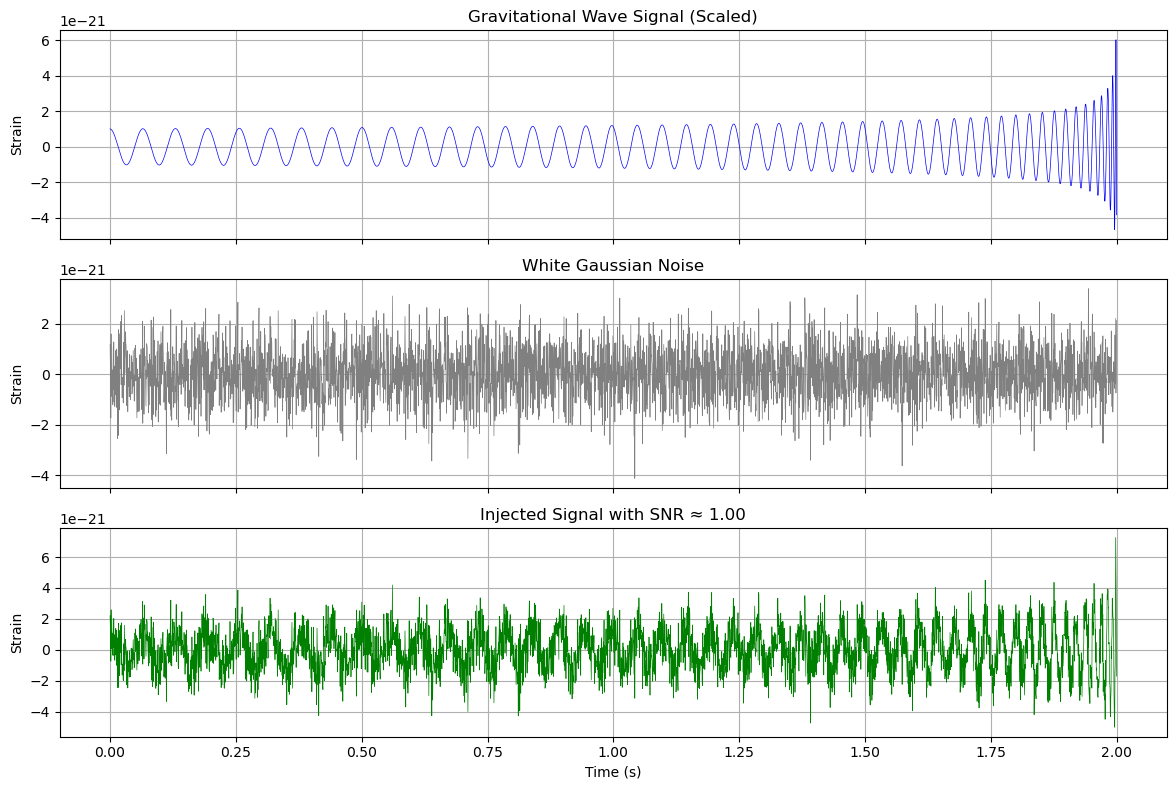

In [3]:
import matplotlib.pyplot as plt

# Example usage
# Simulate waveform and noise
sampling_rate = 2048
duration = 2.0 # seconds
t, h = simulate_gw_inspiral(m1_solar=30, m2_solar=30, DL_Mpc=800, duration=duration, fs=sampling_rate)
_, noise = generate_white_noise(duration=duration, fs=sampling_rate, amplitude=1e-21)
scaled_h, injected, actual_snr = inject_signal_with_snr(h, noise, target_snr=1)

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

axs[0].plot(t, scaled_h, label='Scaled GW Signal', color='blue', lw=0.5)
axs[0].set_ylabel("Strain")
axs[0].set_title("Gravitational Wave Signal (Scaled)")
axs[0].grid(True)

axs[1].plot(t, noise, label='White Noise', color='gray', lw=0.5)
axs[1].set_ylabel("Strain")
axs[1].set_title("White Gaussian Noise")
axs[1].grid(True)

axs[2].plot(t, injected, label='Signal + Noise', color='green', lw=0.5)
axs[2].set_xlabel("Time (s)")
axs[2].set_ylabel("Strain")
axs[2].set_title(f"Injected Signal with SNR ≈ {actual_snr:.2f}")
axs[2].grid(True)

plt.tight_layout()
plt.show()


### Generate GW events

In [22]:
X, y = generate_binary_classification_dataset(num_samples=10000, duration=1.0, fs=512, snr_range=(.1, 3.0))
X = X*1e22

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

# Training a Simple Binary Classifier with **RNN** to detect GW events

## 🧠 Understanding `nn.Sequential` vs Subclassing `nn.Module` in PyTorch

In PyTorch, there are **two main ways** to define neural networks:

---

###  1. Using `nn.Sequential` (Quick and Simple)

This is the **simplest way** to stack layers in order. You use it when your model is **purely feedforward** and has **no branching, shared layers, or custom logic**.

### Example
```python
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(512, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
    nn.Sigmoid()
)
```
This approach is simple, but, it cannot handle multiple inputs/outputs and cannot add loops, conditions, or custom logic.

## 2. Subclass `nn.Module` in PyTorch

In PyTorch, `nn.Module` is the **base class** for all neural network models. Subclassing it gives you **maximum flexibility** to define your own architectures.

###  Why Subclass `nn.Module`?

- You want to define a **custom architecture**
- You need **more control** over the forward pass
- You want to include **conditional logic, loops, multiple branches**, or shared layers

###  How to Subclass `nn.Module`

There are **two key steps**:

1. Define your layers in `__init__()`
2. Define how data flows through them in `forward()`

### Example
```python
import torch
import torch.nn as nn

class SimpleClassifier(nn.Module):
    def __init__(self):
        super(SimpleClassifier, self).__init__()  # Call the parent constructor
        self.fc1 = nn.Linear(512, 64)             # First layer
        self.relu = nn.ReLU()                     # Activation
        self.fc2 = nn.Linear(64, 1)               # Output layer
        self.sigmoid = nn.Sigmoid()               # Binary classification output

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x
```

In [1]:
import torch.nn as nn

In [ ]:
nn.Sequential(nn.Linear(),
              nn.ReLU(),
              nn.Linear(),
              nn.Sigmoid())

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# ---------------------------------------
# 1. Split the data and move it to device
# ---------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train, y_test = y_train.squeeze(), y_test.squeeze()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Convert to PyTorch tensors and move to device
x_train_tensor = torch.as_tensor(X_train).float().to(device)
x_test_tensor = torch.as_tensor(X_test).float().to(device)
y_train_tensor = torch.as_tensor(y_train).float().to(device).unsqueeze(1)  # Make shape [N, 1]
y_test_tensor = torch.as_tensor(y_test).float().to(device).unsqueeze(1)  # Make shape [N, 1]


# You need to reshape the input tensor to be a proper input to the RNN
x_train_tensor = x_train_tensor.unsqueeze(dim=-1)
x_test_tensor = x_test_tensor.unsqueeze(dim=-1)

# ---------------------------------------
# 2. Define the RNN model
# ---------------------------------------
class GWClassifierRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=3):
        super(GWClassifierRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out, _ = self.rnn(x)  # out: [batch, seq_len, hidden]
        out = out[:, -1, :]   # take the last hidden state
        out = self.fc(out)
        return out

model = GWClassifierRNN().to(device)


# ---------------------------------------
# 3. Define loss and optimizer with momentum
# ---------------------------------------
criterion = nn.BCELoss()  # Binary cross-entropy loss

# SGD with momentum
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


# ---------------------------------------
# 4. Train the model
# ---------------------------------------
epochs = 100
loss_vals = []

for epoch in range(epochs):
    model.train()
    y_pred = model(x_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    loss_vals.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:3d} | Loss: {loss.item():.4f}")

Using device: cuda
Epoch  10 | Loss: 0.6911
Epoch  20 | Loss: 0.6846
Epoch  30 | Loss: 0.6782
Epoch  40 | Loss: 0.6711
Epoch  50 | Loss: 0.6623
Epoch  60 | Loss: 0.6503
Epoch  70 | Loss: 0.6326
Epoch  80 | Loss: 0.6057
Epoch  90 | Loss: 0.5652
Epoch 100 | Loss: 0.5046


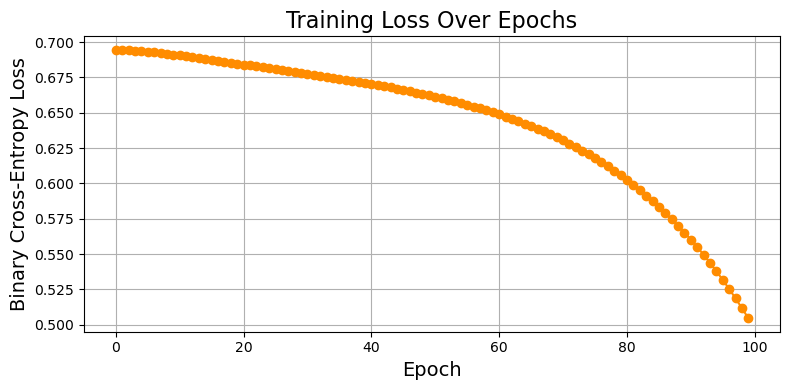

In [28]:
# ---------------------------------------
# 5. Visualize the loss curve
# ---------------------------------------
plt.figure(figsize=(8, 4))
plt.plot(loss_vals, 'o-', color='darkorange')
plt.title("Training Loss Over Epochs", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Binary Cross-Entropy Loss", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
import torchmetrics

acc = torchmetrics.Accuracy(task="binary", num_classes=1)

with torch.no_grad():
    y_hat_test = model(x_test_tensor).cpu()
    print("Accuracy {:.2f}".format(acc(y_hat_test.flatten(), y_test_tensor.cpu().flatten())*100))

Accuracy 89.15


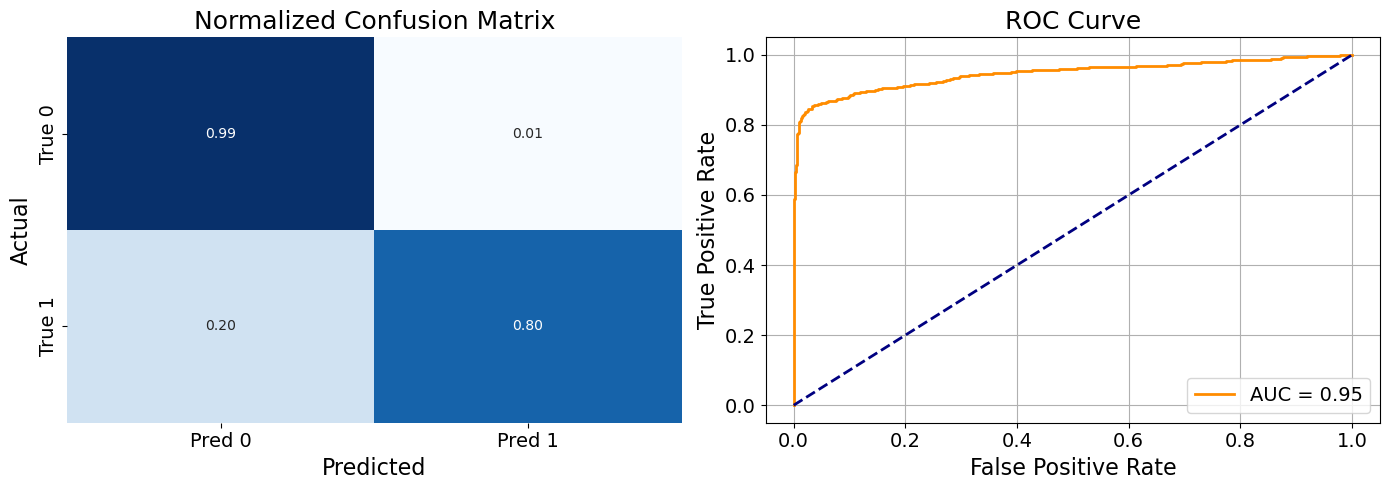

In [30]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Predict on test set
model.eval()
with torch.no_grad():
    y_prob = model(x_test_tensor).cpu().numpy().flatten()
    y_pred = (y_prob > 0.5).astype(int)

# Normalized confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')

# ROC and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix plot
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=False,
            xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'],
            ax=ax1)
ax1.set_title("Normalized Confusion Matrix", fontsize=18)
ax1.set_xlabel("Predicted", fontsize=16)
ax1.set_ylabel("Actual", fontsize=16)
ax1.tick_params(labelsize=14)

# ROC curve plot
ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.2f}")
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_title("ROC Curve", fontsize=18)
ax2.set_xlabel("False Positive Rate", fontsize=16)
ax2.set_ylabel("True Positive Rate", fontsize=16)
ax2.legend(loc="lower right", fontsize=14)
ax2.grid(True)
ax2.tick_params(labelsize=14)

plt.tight_layout()
plt.show()


# Training a Simple Binary Classifier with **GRU** to detect GW events

Using device: cuda
Epoch  10 | Loss: 0.6942
Epoch  20 | Loss: 0.6863
Epoch  30 | Loss: 0.6806
Epoch  40 | Loss: 0.6738
Epoch  50 | Loss: 0.6632
Epoch  60 | Loss: 0.6461
Epoch  70 | Loss: 0.6171
Epoch  80 | Loss: 0.5668
Epoch  90 | Loss: 0.4833
Epoch 100 | Loss: 0.3707


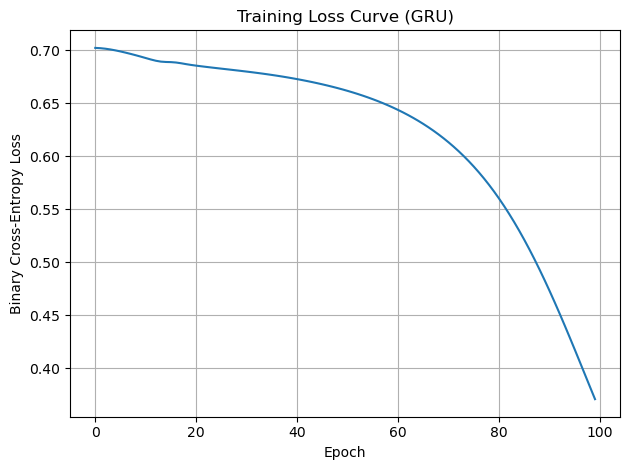

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# ---------------------------------------
# 1. Split the data and move it to device
# ---------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train, y_test = y_train.squeeze(), y_test.squeeze()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Convert to PyTorch tensors and move to device
x_train_tensor = torch.as_tensor(X_train).float().to(device)
x_test_tensor = torch.as_tensor(X_test).float().to(device)
y_train_tensor = torch.as_tensor(y_train).float().to(device).unsqueeze(1)  # Shape: [N, 1]
y_test_tensor = torch.as_tensor(y_test).float().to(device).unsqueeze(1)    # Shape: [N, 1]

# Reshape input to [batch, sequence_len, feature_dim] for GRU
x_train_tensor = x_train_tensor.unsqueeze(-1)  # [N, 512, 1]
x_test_tensor = x_test_tensor.unsqueeze(-1)    # [N, 512, 1]

# ---------------------------------------
# 2. Define the GRU model
# ---------------------------------------
class GWClassifierGRU(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=3):
        super(GWClassifierGRU, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out, _ = self.gru(x)        # out: [batch, seq_len, hidden_size]
        out = out[:, -1, :]         # get last time step
        out = self.fc(out)          # pass through classifier
        return out

model = GWClassifierGRU().to(device)

# ---------------------------------------
# 3. Define loss and optimizer
# ---------------------------------------
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# ---------------------------------------
# 4. Train the model
# ---------------------------------------
epochs = 100
loss_vals = []

for epoch in range(epochs):
    model.train()
    y_pred = model(x_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    loss_vals.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:3d} | Loss: {loss.item():.4f}")

# Optional: Plot loss
plt.plot(loss_vals)
plt.xlabel("Epoch")
plt.ylabel("Binary Cross-Entropy Loss")
plt.title("Training Loss Curve (GRU)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [32]:
import torchmetrics

acc = torchmetrics.Accuracy(task="binary", num_classes=1)

with torch.no_grad():
    y_hat_test = model(x_test_tensor).cpu()
    print("Accuracy {:.2f}".format(acc(y_hat_test.flatten(), y_test_tensor.cpu().flatten())*100))

Accuracy 91.65


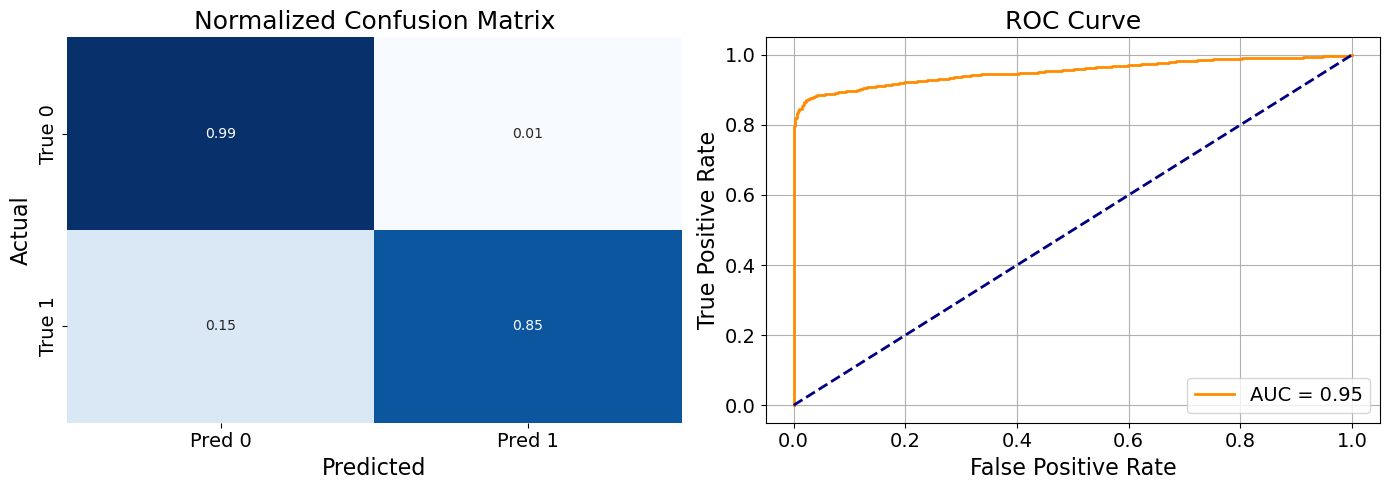

In [33]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Predict on test set
model.eval()
with torch.no_grad():
    y_prob = model(x_test_tensor).cpu().numpy().flatten()
    y_pred = (y_prob > 0.5).astype(int)

# Normalized confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')

# ROC and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix plot
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=False,
            xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'],
            ax=ax1)
ax1.set_title("Normalized Confusion Matrix", fontsize=18)
ax1.set_xlabel("Predicted", fontsize=16)
ax1.set_ylabel("Actual", fontsize=16)
ax1.tick_params(labelsize=14)

# ROC curve plot
ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.2f}")
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_title("ROC Curve", fontsize=18)
ax2.set_xlabel("False Positive Rate", fontsize=16)
ax2.set_ylabel("True Positive Rate", fontsize=16)
ax2.legend(loc="lower right", fontsize=14)
ax2.grid(True)
ax2.tick_params(labelsize=14)

plt.tight_layout()
plt.show()
